In [1]:
%run ./'01 load.ipynb'
pd.options.display.float_format = '{0:,.0f}'.format
pd.options.display.max_rows = 28
pd.options.display.max_rows = 100

Last data for germany: 2020-03-26 18:29:29


In [2]:
len_predictions = 7
rate_death = 0.04014563012 # global as of 2020-03-18
rate_death = 0.008 # luca
rate_icu = 0.14
start_date = '2020-02-26'

In [3]:
germany = df[(df['country'] == 'Germany') & (df['date'] >= '2020-02-03' )]
# germany = df.groupby('date').sum().reset_index() # world
dates_new = pd.date_range(germany['date'].iloc[-1], periods=len_predictions)
df_new = pd.DataFrame(dates_new[1:], columns=['date'])
germany = germany.append(df_new, ignore_index=True)

In [4]:
germany['growth'] = germany['confirmed'].pct_change() * 100

In [5]:
len_before_start = (germany['date'] < start_date).sum()
len_after_start = (germany['date'] >= start_date).sum()

In [6]:
# prepare machine learning magic
y = germany.iloc[len_before_start:]['confirmed'].dropna()
x = list(range(len(y)))
# magic
from scipy.optimize import curve_fit
def func(x, a, d):
    return a**x + d
popt, pcov = curve_fit(func, x, y)
print(*popt)
print(*pcov)

1.4514394810099023 4015.8736708407514
[ 2.03464479e-05 -1.98066190e+00] [-1.98066190e+00  1.17461709e+06]


In [7]:
# get x values from predictor
predict = []
for i in range(len_after_start+len_predictions):
    prediction = func(i, *popt)
    prediction = 0 if prediction < 0 else round(prediction, -2)
    predict.append(prediction)
germany = germany.join(pd.DataFrame(enumerate(predict, len_before_start), columns=['id', 'predict']).set_index('id'))    

In [8]:
germany['predict'] = germany['predict'].fillna(0)

In [9]:
germany['growth_predict'] = germany['predict'].pct_change() * 100

In [10]:
# predict deaths based on prediction of cases and death rate (see top)
germany['predict_deaths'] = germany['predict'] * rate_death
germany['predict_icu'] = germany['predict'] * rate_icu

In [11]:
germany['date_string'] = germany['date'].dt.strftime('%d. %b')

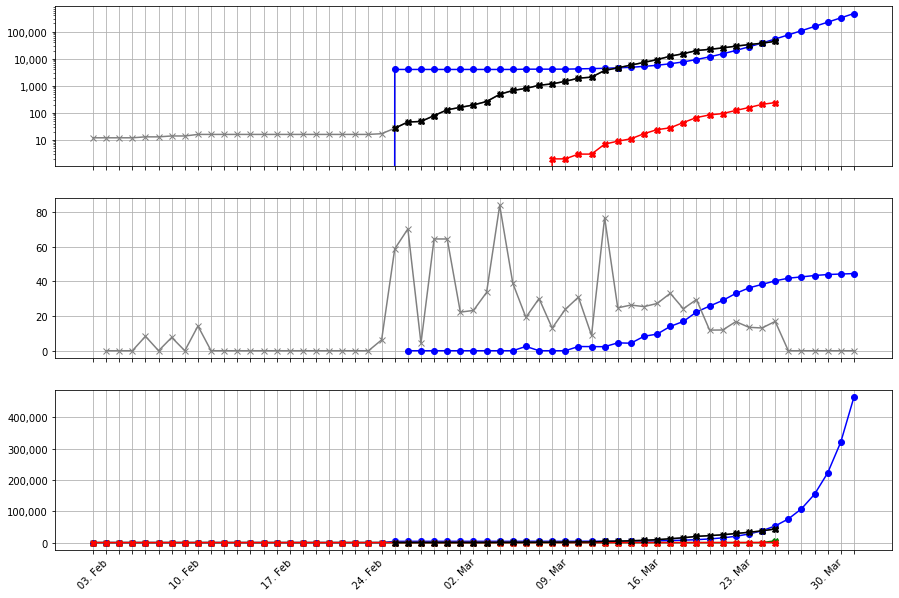

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker
format_y = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
x = list(germany['date_string'])
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(3,1,1)
ax1.grid(True)
ax1.plot(germany['date_string'], germany['predict'], marker='o', color='blue')
ax1.plot(germany['date_string'], germany['confirmed'], marker='x', color='gray')
ax1.plot(germany['date_string'], germany['deaths'], marker='X', color='red')
ax1.plot(germany.iloc[len_before_start:]['date_string'], germany.iloc[len_before_start:]['confirmed'], marker='X', color='black')
#ax1.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
#ax1.plot(germany['date_string'], germany['predict_deaths'], marker='o', color='orange')
ax1.set_yscale('log')
ax1.yaxis.set_major_formatter(format_y)

ax2 = fig.add_subplot(3,1,2, sharex=ax1)
ax2.grid(True)
ax2.plot(germany['date_string'], germany['growth_predict'], marker='o', color='blue')
ax2.plot(germany['date_string'], germany['growth'], marker='x', color='gray')
ax2.yaxis.set_major_formatter(format_y)

ax3 = fig.add_subplot(3,1,3, sharex=ax1)
ax3.grid(True)
ax3.plot(germany['date_string'], germany['predict'], marker='o', color='blue')
ax3.plot(germany['date_string'], germany['confirmed'], marker='x', color='gray')
ax3.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
ax3.plot(germany['date_string'], germany['deaths'], marker='X', color='red')
ax3.plot(germany.iloc[len_before_start:]['date_string'], germany.iloc[len_before_start:]['confirmed'], marker='X', color='black')
#ax3.plot(germany['date_string'], germany['recovered'], marker='X', color='green')
#ax3.plot(germany['date_string'], germany['predict_deaths'], marker='o', color='orange')
ax3.set_xticklabels(labels=germany['date_string'], rotation=45)
ax3.yaxis.set_major_formatter(format_y)
labels = ax3.xaxis.get_ticklabels()
for label in labels:
    label.set_visible(False)
for label in labels[::7]:
    label.set_visible(True)
for ax in fig.get_axes():
    ax.label_outer()

In [13]:
germany.iloc[-len_predictions-5:]

,index,country,confirmed,deaths,recovered,active,date,date_string,growth,predict,growth_predict,predict_deaths,predict_icu
47,"4,027",Germany,"22,213",84,0,0,2020-03-21 23:59:59,21. Mar,12,"11,700",26,94,"1,638"
48,"4,028",Germany,"24,873",94,0,0,2020-03-22 23:59:59,22. Mar,12,"15,100",29,121,"2,114"
49,"4,029",Germany,"29,056",123,0,0,2020-03-23 23:59:59,23. Mar,17,"20,100",33,161,"2,814"
50,"4,030",Germany,"32,986",157,0,0,2020-03-24 23:59:59,24. Mar,14,"27,400",36,219,"3,836"
51,"4,031",Germany,"37,323",206,0,0,2020-03-25 23:59:59,25. Mar,13,"37,900",38,303,"5,306"
52,7,Germany,"43,646",239,"5,673","37,734",2020-03-26 18:29:29,26. Mar,17,"53,200",40,426,"7,448"
53,nan,NaN,nan,nan,nan,nan,2020-03-27 18:29:29,27. Mar,0,"75,500",42,604,"10,570"
54,nan,NaN,nan,nan,nan,nan,2020-03-28 18:29:29,28. Mar,0,"107,700",43,862,"15,078"
55,nan,NaN,nan,nan,nan,nan,2020-03-29 18:29:29,29. Mar,0,"154,500",43,"1,236","21,630"
56,nan,NaN,nan,nan,nan,nan,2020-03-30 18:29:29,30. Mar,0,"222,500",44,"1,780","31,150"
